# Deploy MusicGen Large on SageMaker Async Inference Endpoint

## Suggested SageMaker Environment

Image: Data Science 3.0
Kernel: Python 3
Instance Type: ml.t3.medium

## Objective

In this notebook we will deploy AudioCraft Musicgen model available on https://huggingface.co/facebook/musicgen-large on Amazon SageMaker. We will be deploying it to the SageMaker Async Inferernce endpoint.



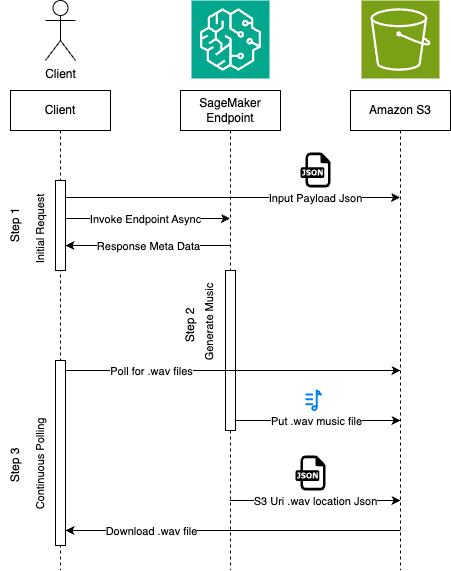

Install necessary packages to run this notebook on SageMaker Studio.

In [ ]:
!pip install -Uq pip
!pip install -Uq sagemaker

## Prepare Inference Scripts

We will create model directory that holds the code artefacts such as inference python script and the requirements.txt that holds all the relevant python packages that will be installed when the model is deployed.

In [ ]:
!mkdir model
!mkdir model/code

Let's create `requirements.txt` file that holds necessary packages for serving the musicgen model.

In [ ]:
## requirements.txt https://github.com/facebookresearch/audiocraft/blob/main/README.md
'''
# Best to make sure you have torch installed first, in particular before installing xformers.
# Don't run this if you already have PyTorch installed.
pip install 'torch>=2.0'
# Then proceed to one of the following
pip install -U audiocraft  # stable release
pip install -U git+https://git@github.com/facebookresearch/audiocraft#egg=audiocraft  # bleeding edge
pip install -e .  # or if you cloned the repo locally (mandatory if you want to train).
'''
with open("model/code/requirements.txt", "w") as f:
    f.write("transformers==4.37.1\n")
    f.write("boto3\n")
    f.write("torch>=2.1\n")
    f.write("scipy\n")
    f.write("uuid\n")
    f.write("audiocraft\n")
    f.write("git+https://git@github.com/facebookresearch/audiocraft#egg=audiocraft\n")


We will now create `inference.py` that holds the serving logic for musicgen model on SageMaker Async inference endpoint.

In [ ]:
%%writefile model/code/inference.py
import uuid
import os
import logging
import torch
from transformers import AutoProcessor, MusicgenForConditionalGeneration
import boto3
import scipy


# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

logger = logging.getLogger(__name__)


def model_fn(model_dir):
    '''loads model'''
    model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-large")
    #model.to(DEVICE)
    return model


def _process_input(data):
    # defaults
    default_generation_params = {
        'guidance_scale': 3,
        'max_new_tokens': 256,
        'do_sample': True,
        'temperature': 1 
        }
    default_texts = ["Morning sunshine, beats, ukelele, happy swings"]
    # obtain input data
    texts = data.get('texts', default_texts)
    config = data.get('generation_params', default_generation_params)
    guidance_scale = config.get('guidance_scale', default_generation_params.get('guidance_scale'))
    max_new_tokens = config.get('max_new_tokens', default_generation_params.get('max_new_tokens'))
    temperature = config.get('temperature', default_generation_params.get('temperature'))
    do_sample = config.get('do_sample', default_generation_params.get('do_sample'))
    generation_params = {
        'guidance_scale': guidance_scale, 
        'do_sample': do_sample,
        'max_new_tokens': max_new_tokens,
        'temperature': temperature
    }
    return texts, generation_params


def _upload_to_s3(wav_on_disk, bucket_name):
    # https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3/object/upload_fileobj.html
    target_file = wav_on_disk.split('/')[-1]
    prefix = 'musicgen_large/output'
    key = f'{prefix}/{target_file}'

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    obj = bucket.Object(key)

    with open(wav_on_disk, 'rb') as data:
        obj.upload_fileobj(data)

    return f"s3://{obj.bucket_name}/{obj.key}"


def _upload_wav_files(disk_wav_locations, bucket_name):
    upload_paths = []
    for loc in disk_wav_locations:
        try:
            uri = _upload_to_s3(loc, bucket_name)
            upload_paths.append(uri)
        except Exception as e:
            logger.exception('error uploading %s: %s', loc, e)

    return upload_paths


def _write_wavs_to_disk(sampling_rate, audio_values):
    r = len(audio_values)
    prefix = str(uuid.uuid1())
    disk_wav_locations = []
    for i in range(r):
        # Write wav to Disk
        wav_file = f"musicgen_large_out_{prefix}_{i}.wav"
        wav_on_disk = f'/tmp/{wav_file}'
        scipy.io.wavfile.write(wav_on_disk,
                                rate=sampling_rate,
                                data=audio_values[i, 0].cpu().numpy()
                            )
        disk_wav_locations.append(wav_on_disk)
    return disk_wav_locations


def _delete_file_on_disk(filename):
    if os.path.isfile(filename):
        os.remove(filename)


def predict_fn(data, model):
    '''generates the music from the input data'''
    result_dict = {
            "generated_outputs_s3": []
        }
    try:
        # https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor.predict
        bucket_name = data.pop('bucket_name', None)
        if not bucket_name:
            raise ValueError("bucket_name is required ex: sagemaker_default_bucket_007")
        texts, generation_params = _process_input(data)
        processor = AutoProcessor.from_pretrained("facebook/musicgen-large")
        inputs = processor(
            text = texts,
            padding=True,
            return_tensors="pt",
        )
        logger.info('start generate music')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        audio_values = model.generate(**inputs.to(device),
                                      **generation_params)

        logger.info('end generate music')
        # process generated output audio_values
        sampling_rate = model.config.audio_encoder.sampling_rate

        disk_wav_locations = _write_wavs_to_disk(sampling_rate, audio_values)

        # Upload wavs to S3
        result_dict["generated_outputs_s3"] = _upload_wav_files(disk_wav_locations, bucket_name)
        # Clean up disk
        for wav_on_disk in disk_wav_locations:
            _delete_file_on_disk(wav_on_disk)
    except Exception as e:
        logger.exception('error while prediction: %s', e)

    logger.info('end predict_fn')
    return result_dict

In [ ]:
%cd model

## Place the inference scripts archive on Amazon S3

We will create the archive of the inference scripts and upload those to Amazon S3 bucket. The uploaded uri of this object on S3 will later be used to create the HuggingFace Model.

In [ ]:
!rm model.tar.gz
!rm -rf code/.ipynb_checkpoints*
!tar zcvf model.tar.gz *

We will obtain the basic details such as SageMaker execution role, session, region and default bucket.

In [ ]:
import sagemaker
import boto3

sess = sagemaker.Session()

sagemaker_session_bucket = None
if sagemaker_session_bucket is None and sess is not None:
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
region = sess.boto_region_name
print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {region}")


Let's organize files utilized for serving musicgen model on S3 in it's destined prefix and then upload the model artifacts archive `model.tar.gz` to s3.

In [ ]:
musicgen_prefix = 'musicgen_large'
s3_model_key = f'{musicgen_prefix}/model/model.tar.gz'
s3_model_location = f"s3://{sagemaker_session_bucket}/{s3_model_key}"
s3 = boto3.resource("s3")
s3.Bucket(sagemaker_session_bucket).upload_file("model.tar.gz", s3_model_key)

## Deploy Asynchronous Inference Endpoint on Amazon SageMaker

To create the Asynchronous Inference Endpoint, we will perform the following steps:

1. Obtain the AWS DLC for Large Model Inference from [pre-built HuggingFace Inference Containers](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#huggingface-inference-containers)
2. Create a model of type HuggingFaceModel since we are using the musicgen large model from HuggingFace as model provider. 
3. We then create an asynchronous endpoint configuration whose notification configuration is associated to Amazon SNS for success and error topics. 
4. We will finally deploy the model to generate a SageMaker Endpoint for asynchronous inferencing.

In [ ]:
instance_type="ml.g5.2xlarge"

### (Optional) Obtain AWS DLC for Large Model Inference

In case you want to deploy to DLC, programmatically obtain AWS DLC for HF LMI from SageMaker. 
Refer to latest image uris here: https://github.com/aws/deep-learning-containers/blob/master/available_images.md#huggingface-inference-containers

In [ ]:
from sagemaker import image_uris
image_uri = image_uris.retrieve(
                framework='huggingface',
                region=region,
                version='4.37.0',
                image_scope='inference',
                base_framework_version='pytorch2.1.0',
                instance_type=instance_type)

### Create a Model

We will now initialize HuggingFaceModel with the necessary arguments. The `env` argument accepts a dictionary of parameters such as `TS_MAX_REQUEST_SIZE` and `TS_MAX_RESPONSE_SIZE` that holds the byte size values for request and response payloads to the async inference endpoint. The `TS_DEFAULT_RESPONSE_TIMEOUT` key in the `env` dictionary represents the timeout in seconds after which the async inference endpoint stops responding.

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
from sagemaker.s3 import s3_path_join
from sagemaker.utils import name_from_base

async_endpoint_name = name_from_base("musicgen-large-v1-async")

# create Hugging Face Model Class
# AudioCraft's models requires Python 3.9, PyTorch 2.0.0 or latest. (https://github.com/facebookresearch/audiocraft/blob/main/README.md)

huggingface_model = HuggingFaceModel(
    name=async_endpoint_name,
    #image_uri=image_uri,
    model_data=s3_model_location,  # path to your model and script
    role=role,
    env= { #https://docs.aws.amazon.com/sagemaker/latest/dg/async-inference-create-endpoint.html
           'TS_MAX_REQUEST_SIZE': '100000000',
           'TS_MAX_RESPONSE_SIZE': '100000000',
           'TS_DEFAULT_RESPONSE_TIMEOUT': '3600'
       },# iam role with permissions to create an Endpoint
    transformers_version="4.37",  # transformers version used
    pytorch_version="2.1",  # pytorch version used
    py_version="py310",  # python version used
)

### Asynchronous Inference Configuration

#### Create Amazon SNS topics for Success and Failure Notification configuration

Let's initialize the code for SnsClient to create SNS topics for success and Failure notifications which we will associate with the `AsyncInferenceConfig`'s `notification_cofnig` later in this notebook.

In [ ]:
%cd ..

In [ ]:
import sys, os
# https://stackoverflow.com/a/8015152
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from utils.sns_client import SnsClient
del sys.path[0]

In [ ]:
# Create SNS topic
import time
#from utils.sns_client import SnsClient

sns_client = SnsClient(boto3.client("sns"))
timestamp = time.time_ns()
topic_names = [f"musicgen-large-topic-SuccessTopic-{timestamp}", f"musicgen-large-topic-ErrorTopic-{timestamp}"]

topic_arns = []
for topic_name in topic_names:
    print(f"Creating topic {topic_name}.")
    response = sns_client.create_topic(topic_name)
    topic_arns.append(response.get('TopicArn'))

In [ ]:
topic_arns

#### Create Async Inference Configuration and associate SNS topics using notification configuration

We will now create `AsyncInferenceConfig` object and define the following arguments
- `output_path`: The location where the output of the async inference endpoint will be placed. The files in this location has .out extension and holds the details of async inference performed by the musicgen model.
- `notification_config`: Optionally, you can associate success and error SNS topics and let dependent workflows poll to these topics to take informed decisions.

In [ ]:
# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=s3_path_join(
        "s3://", sagemaker_session_bucket, "musicgen_large/async_inference/output"
    ),  # Where our results will be stored
    # Add nofitication SNS if needed
    notification_config={
        "SuccessTopic": topic_arns[0],
        "ErrorTopic": topic_arns[1],
    },  #  Notification configuration
)

### Deploy the model to generate a SageMaker Endpoint for asynchronous inferencing

With the async inference confg defined, we proceed with deploying the HuggingFace model with `initial_instance_count` set to 1.

In [ ]:
# deploy the endpoint
async_predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    async_inference_config=async_config,
    endpoint_name=async_endpoint_name,
)

Let's save the variables that will be re-used in the infer notebook.

In [ ]:
endpoint_name=async_predictor.endpoint_name

In [ ]:
%store \
endpoint_name \
sagemaker_session_bucket \
topic_arns

In [ ]:
endpoint_name

Meanwhile the model gets deployed, you can refer to the following info about Amazon SageMaker and Facebook Musicgen.
- https://huggingface.co/facebook/musicgen-large
- https://huggingface.co/docs/transformers/model_doc/musicgen#generation
- https://github.com/facebookresearch/audiocraft/blob/main/README.md
- https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html#hugging-face-model
- https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor.predict
- https://github.com/aws/amazon-sagemaker-examples/blob/main/async-inference/Transcription_on_SM_endpoint.ipynb